# NCoR QC

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2

In [45]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
matplotlib.rcParams['savefig.dpi'] = 100
import seaborn as sns
%matplotlib inline

## Preprocessing

In [32]:
# file directories
workingDirectory = '/home/jtao/analysis/ncor_analysis/'
peakDirectory = '/home/jtao/analysis/ncor_analysis/peak_files/'
scratchDirectory = '/home/jtao/analysis/ncor_analysis/scratch/'
tagDirPath = '/home/jtao/analysis/ncor_analysis/tag_directories_chip/'

binDirectory = '/home/jtao/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'

os.chdir(workingDirectory)

# read in and parse name mapping file and create a DataFrame representation

strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
sampleNames = []

for sample in sorted(os.listdir(tagDirPath)):
    metaDataTokens = sample.strip().split("_")
    
    sampleNames.append(sample)
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
# _sampleNames = []
_totalReads = []
_tagsPerPosition = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        uniquePositions  =  int(data[1].split()[1])
        totalReads=  float(data[1].split()[2])
        fragmentLengthEstimate = float(data[2].split('=')[1])
        tagsPerBP = float(data[4].split('=')[1])
        averageTagsPerPosition = float(data[5].split('=')[1])
        averageTagLength = float(data[6].split('=')[1])
        averageFragmentGCcontent = float(data[8].split('=')[1])
        _sampleNames.append(tagdir)
        _tagsPerPosition.append(averageTagsPerPosition)
        _totalReads.append(totalReads)
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _tagsPerPosition]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'tagsPerPosition']


summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
mapping_summary_frame = summary_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:99: FutureWarning: sort(....) is deprecated, use sort_index(.....)


## Mapping Quality Control

In [200]:
if not os.path.exists(scratchDirectory):
    os.mkdir(scratchDirectory)

# delete all empty files
if os.path.exists(scratchDirectory):
    for f in os.listdir(scratchDirectory):
        if os.stat(scratchDirectory + '/' + f).st_size == 0 and 'annotated' in f:
            os.remove(scratchDirectory + '/' + f)

scriptFile = open(scratchDirectory + '/homer_peak_annotation.sh', 'w')

count = 0 
sleepTime = 0
peakFiles = os.listdir(peakDirectory)
for peakFile in peakFiles:
    if "homer_peaks" in peakFile:
        annotatedFile = peakFile.replace("_homer_peaks.tsv","") + "_homer_annotated.tsv"
        simpleName_sampleName_dict[peakFile.replace("_homer_peaks.tsv","")]
        tagDir1 = cleanedName_originalName_dict[simpleName_sampleName_dict[peakFile.replace("_homer_peaks.tsv","")]]
        # annotate peaks with tag counts
        count += 1
        if count == 10:
            count = 0
            sleepTime += 1
        scriptFile.write('(sleep ' + str(sleepTime) +'m; annotatePeaks.pl '+
                         peakDirectory + '/' + peakFile +
                         ' mm10 -noadj -noann -nogene -d ' +
                         tagDirectory + '/' + tagDir1 + '> ' +
                         scratchDirectory + '/' + annotatedFile +') & \n')
scriptFile.close()

# run script
! bash $scratchDirectory/homer_peak_annotation.sh

## Call Peaks

In [22]:
inputDirectory = './input/'
tagDirectory = './tag_directories_chip/'
veh_input_dict = {'14-11-04':inputDirectory + 'Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-03-19':inputDirectory + 'Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-03-19-rep2':inputDirectory + 'Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-07-07':inputDirectory + 'Sample_NCoRWT_BMDM_Input-Form_NoTx_JSS_14_11_04',
                  '14-10-23':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_NoTx_JSS_14_10_23',
                  '14-09-17':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_NoTx_JSS_14_09_17',
                  '15-02-02':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_NoTx_JSS_15_02_02',
                  '15-02-17':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_NoTx_JSS_15_02_02'
                  }
kla_input_dict = {'14-11-04':inputDirectory + 'Sample_NCoRWT_BMDM_Input-DSG_KLA_1h_JSS_14_11_04',
                  '14-03-19':inputDirectory + 'Sample_NCoRWT_BMDM_Input-DSG_KLA_1h_JSS_14_11_04',
                  '14-03-19-rep2':inputDirectory + 'Sample_NCoRWT_BMDM_Input-DSG_KLA_1h_JSS_14_11_04',
                  '14-07-07':inputDirectory + 'Sample_NCoRWT_BMDM_Input-DSG_KLA_1h_JSS_14_11_04',
                  '14-10-23':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_KLA_1h_JSS_14_10_23',
                  '14-09-17':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_KLA_1h_JSS_14_09_17',
                  '14-09-26':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_NCoR-p65-Input_KLA_1h_JSS_14_09_17',
                  '15-02-02':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_KLA_1h_JSS_15_02_02',
                  '15-02-17':inputDirectory + 'Sample_Coro2AWT_BMDM_ChIP_Input_KLA_1h_JSS_15_02_02'
                  }

# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
scriptFile = open(scratchDirectory + '/peakCalling_homer_relaxed.sh', 'w')
for tagDir in os.listdir(tagDirectory):
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    strain = metaDataTokens[0]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]
    print(tagDir)
    peakFileName = tagDir + "_homer_relaxed_peaks.tsv"
    if "veh" in treatment.lower():
        inputDir = veh_input_dict[date]
    elif "kla" in treatment.lower():
            inputDir = kla_input_dict[date]
    scriptFile.write('findPeaks ' + tagDirectory + '/' + tagDir + 
                     ' -i ' + inputDir + 
                     ' -L 0 -C 0 -fdr 0.9 -style factor -size 200  > ' + 
                     peakDirectory + peakFileName + ' &\n')

scriptFile.close()


C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_Veh_Josh_14-07-07
C57Bl6_BMDM_ChIP_NCoR_Veh_JS_14-10-23
C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_KLA-1h_Josh_14-03-19-rep2
C57Bl6_BMDM_ChIP_NCoR_KLA_JS_14-09-26
C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_Veh_Josh_15-02-17
C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_KLA-1h_Josh_15-02-17
C57Bl6_BMDM_ChIP_NCoR_KLA_JS_14-07-07
C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_KLA-1h_Josh_14-07-07
C57Bl6_BMDM_ChIP_NCoR_Veh_JS_14-07-07
C57Bl6_BMDM_ChIP_NCoR_Veh_JS_14-11-04
C57Bl6_BMDM_ChIP_NCoR_Veh_JS_14-03-19
C57Bl6_BMDM_ChIP_NCoR_KLA_JS_14-03-19
C57Bl6_BMDM_ChIP_NCoR_KLA_JS_14-09-17
C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_Veh_Josh_14-03-19
C57Bl6_BMDM_ChIP_NCoR_KLA_JS_15-02-02
C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_KLA-1h_JSS_14-11-04
C57Bl6_BMDM_ChIP_NCoR_KLA_JS_14-10-23
C57Bl6_BMDM_ChIP_NCoR_Veh_JS_15-02-02
C57Bl6_BMDM_ChIP_NCoR_KLA_JS_14-11-04
C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_Veh_JSS_14-11-04
C57Bl6_BMDM_ChIP_NCoR_Veh_JS_14-09-17
C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_KLA-1h_Josh_14-03-19


In [24]:
%%bash
bash ./scratch//peakCalling_homer_relaxed.sh

	Fragment Length = 155
	Total Tags = 6538134.0
	Tags per bp = 0.003269
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 146
	Total Tags = 12637547.0
	Tags per bp = 0.006319
	Max tags per bp set automatically to 1.0
	Fragment Length = 122
	Total Tags = 9427080.0
	Tags per bp = 0.004714
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 237
	Total Tags = 4569949.0
	Tags per bp = 0.002285
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 157
	Total Tags = 8111362.0
	Tags per bp = 0.004056
	Max tags per bp set automatically to 1.0
	Fragment Length = 199
	Total Tags = 4426044.0
	Tags per bp = 0.002213
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Finding peaks of size 200, no closer than 400
	Finding peaks of size 200, no closer than 400
	Fragment Length = 120
	Total Tags = 11

## Run IDR

In [36]:
filtered_summary_frame = summary_frame

In [40]:

idrDirectory = '/home/jtao/analysis/ncor_analysis/idr/'
scriptFile = open(scratchDirectory + '/run_idr.sh', 'w')

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./idr/*
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
counter = 0
for ri in replicateIndices:
    samples = filtered_summary_frame.ix[ri, 'sampleName'].values
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + "_homer_relaxed_peaks.tsv"
            peakFile2 = peakDirectory + '/' + sample2 + "_homer_relaxed_peaks.tsv"
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.01"
            else: 
                commandString += " -threshold 0.05"            
            if not counter % 12 == 0:
                commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

rm: cannot remove ‘./idr/*’: No such file or directory


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:75: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [41]:
%%bash
rm ./idr/*
chmod a+x ./scratch/*
bash ./scratch/run_idr.sh

Process is interrupted.


In [47]:
factorTreatment

'C57Bl6_BMDM_ChIP'

In [49]:
p.split('_')[:5]

['C57Bl6', 'BMDM', 'ChIP', 'NCoR', 'KLA']

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(....) is deprecated, use sort_index(.....)


(array([0]), <a list of 1 Text xticklabel objects>)

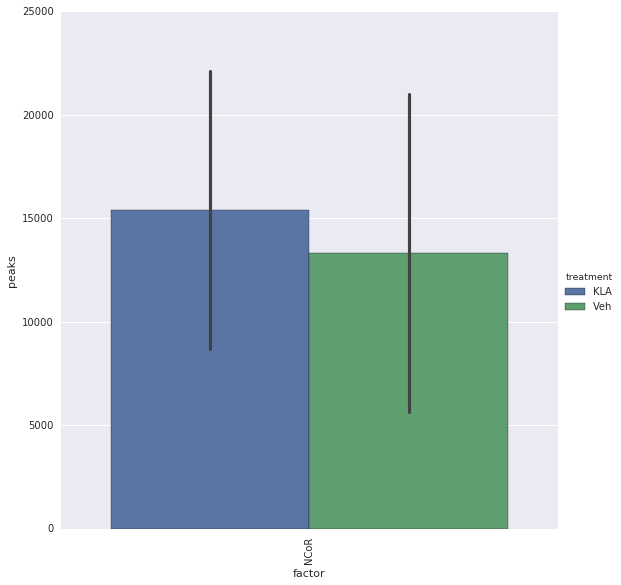

In [51]:
# pick the IDR results that have the most peaks
idrDirectory = '/home/jtao/analysis/ncor_analysis/idr/'
factorTreatment_bestIDR_dict = {}
factorTreatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        factorTreatment = '_'.join(p.split('_')[:5])
        if factorTreatment in factorTreatment_peakNumber_dict:
            if factorTreatment_peakNumber_dict[factorTreatment] < numPeaks:
                factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
                factorTreatment_bestIDR_dict[factorTreatment] = p
        else:
            factorTreatment_peakNumber_dict[factorTreatment] = numPeaks
            factorTreatment_bestIDR_dict[factorTreatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for factorTreatment in factorTreatment_peakNumber_dict.keys():
    tokens = factorTreatment.split('_')
    strains.append(tokens[0])
    factors.append(tokens[3])
    treatments.append(tokens[4].split('-')[0])
    numPeaks.append(factorTreatment_peakNumber_dict[factorTreatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'factor':factors,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['factor'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='factor', y='peaks', data = idrPeak_frame, hue='treatment', size =8, kind='bar')
plt.xticks(rotation=90)
# plt.ylim([0,30000])
    

In [56]:
p

'C57Bl6_BMDM_ChIP_NCoR_Veh_JS_14-11-04_homer_relaxed_peaks_C57Bl6_BMDM_ChIP_NCoR_Veh_JS_15-02-02_homer_relaxed_peaks_idr.tsv'

In [55]:
outFile = open('./best_samples.tsv','w')
! if [ ! -d idrPeaks ]; then mkdir idrPeaks; fi
!rm ./idrPeaks/*
for key in sorted(factorTreatment_bestIDR_dict.keys()):
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[3]
    treatment = tokens[4].split('-')[0]
    sample1 = '_'.join(tokens[:5])
    sample2 = '_'.join(tokens[6:11])
    outFile.write('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key]),'\n']))
    print('\t'.join([strain, factor, treatment, sample1, sample2, str(factorTreatment_peakNumber_dict[key])]))

    if factorTreatment_peakNumber_dict[key] > 0:
        outpath = './idrPeaks/' + '_'.join([strain, factor, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()






rm: cannot remove ‘./idrPeaks/*’: No such file or directory
C57Bl6-NCoR-KO	NCoR	KLA	C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_KLA-1h	14-11-04_homer_relaxed_peaks_C57Bl6-NCoR-KO	8658
C57Bl6-NCoR-KO	NCoR	Veh	C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_Veh	14-11-04_homer_relaxed_peaks_C57Bl6-NCoR-KO	5652
C57Bl6	NCoR	KLA	C57Bl6_BMDM_ChIP_NCoR_KLA	14-10-23_homer_relaxed_peaks_C57Bl6	22116
C57Bl6	NCoR	Veh	C57Bl6_BMDM_ChIP_NCoR_Veh	14-11-04_homer_relaxed_peaks_C57Bl6	21008


### Make Multiwig Hub

In [60]:
tokens

['C57Bl6',
 'BMDM',
 'ChIP',
 'NCoR',
 'KLA',
 'JS',
 '14-10-23',
 'homer',
 'relaxed',
 'peaks',
 'C57Bl6',
 'BMDM',
 'ChIP',
 'NCoR',
 'KLA',
 'JS',
 '14-11-04',
 'homer',
 'relaxed',
 'peaks',
 'idr.tsv']

In [66]:
# create track hub containing best samples
tagDirectories = []
# for key in sorted(factorTreatment_bestIDR_dict.keys()):
for key in factorTreatment_bestIDR_dict:
    p = factorTreatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = '_'.join(tokens[:7])
    sample2 = '_'.join(tokens[10:17])
#     print(sample1,'\n', sample2)
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories_chip/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl ncor_idr_best mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 1e6 -d $tagDirString
! makeMultiWigHub.pl ncor_idr_best mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 1e6 -d $tagDirString

makeMultiWigHub.pl ncor_idr_best mm10 -force -normLength 150 -fragLength 150 -tbp 1 -norm 1e6 -d ./tag_directories_chip/C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_KLA-1h_JSS_14-11-04 ./tag_directories_chip/C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_KLA-1h_Josh_14-03-19 ./tag_directories_chip/C57Bl6_BMDM_ChIP_NCoR_Veh_JS_14-11-04 ./tag_directories_chip/C57Bl6_BMDM_ChIP_NCoR_Veh_JS_15-02-02 ./tag_directories_chip/C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_Veh_JSS_14-11-04 ./tag_directories_chip/C57Bl6-NCoR-KO_BMDM_ChIP_NCoR_Veh_Josh_15-02-17 ./tag_directories_chip/C57Bl6_BMDM_ChIP_NCoR_KLA_JS_14-10-23 ./tag_directories_chip/C57Bl6_BMDM_ChIP_NCoR_KLA_JS_14-11-04

	Once finished, you will want to upload the following hub URL:
		http://homer.ucsd.edu/hubs//ncor_idr_best/hub.txt

	If loading to the Wash U Epigenome Browser, use:
		http://homer.ucsd.edu/hubs//ncor_idr_best/washU.hub.txt

	Overwriting contents in /homer_data/www/html/hubs//ncor_idr_best

	Visualization fragment length = 150
	Output file: ./tag_directories_chip/C57B